In [1]:
import warnings
from helper import *

In [2]:
# basic configuration
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 500)

In [8]:
formatted_df = pd.read_csv("pipe_dataset.csv", index_col=0)
formatted_df.index = pd.to_datetime(formatted_df.index)
formatted_df.head()

8705902546  8716113919  8718640762  8718640763  8718640787  \
2021-09-26       102.0       102.0      2192.0      2168.0      2168.0   
2021-10-03      2130.0      2130.0      2357.0      3253.0      3253.0   
2021-10-10      1398.0      1758.0      4918.0      4842.0      4842.0   
2021-10-17       600.0       654.0      2897.0      2537.0      2537.0   
2021-10-24      2190.0      2748.0       860.0      1308.0      1308.0   

            8718645319  8718647378  8718649158  8718649167  8718649588  \
2021-09-26      2352.0      2376.0      5547.0      5547.0      5371.0   
2021-10-03       484.0       484.0      4800.0      4800.0      4800.0   
2021-10-10      3196.0      3236.0      3426.0      3426.0      3426.0   
2021-10-17      4774.0      4782.0      7874.0      7874.0      7874.0   
2021-10-24      5556.0      5556.0      7025.0      7025.0      7025.0   

            8718649589  8718651804  8718653366  8718654166  8718696020  \
2021-09-26      3481.0       102.0       102.0      2376.0       102.0   
2021-10-03      2538.0      2130.0      2130.0       484.0      2130.0   
2021-10-10      2034.0      1758.0      1398.0      3236.0      1758.0   
2021-10-17      1902.0       654.0       600.0      4782.0       654.0   
2021-10-24      3791.0      2748.0      2190.0      5556.0      2748.0   

            8718696337  8718698387  8718699250  8719905826  8750306523  
2021-09-26       102.0       102.0       102.0      2956.0       102.0  
2021-10-03      2130.0      2130.0      2130.0      2064.0      2130.0  
2021-10-10      1758.0      1758.0      1758.0      3205.0      1758.0  
2021-10-17       654.0       654.0       654.0      1444.0       654.0  
2021-10-24      2748.0      2748.0      2748.0      2154.0      2748.0

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

configure_matplotlib(transparent=False)
for i in range(0, len(formatted_df.columns)):
    selected_pipe = formatted_df.columns[0]
    seasons = seasonal_decompose(formatted_df[selected_pipe], model='additive', period=7, filt=None, two_sided=True, extrapolate_trend=0)
    ax = plt.subplot(len(formatted_df.columns), 1, i + 1)
    ax.figure.set_size_inches(20, i * 3)
    ax.figure.set_dpi(300)
    seasons.seasonal.plot(ax=ax, legend=False, marker='o', markersize=7, linewidth=2)
    ax.set_title(f"Pipe TTNr: {formatted_df.columns[i]}", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.margins(x=40)
    plt.subplots_adjust(hspace=1, wspace=0)
    
plt.show()

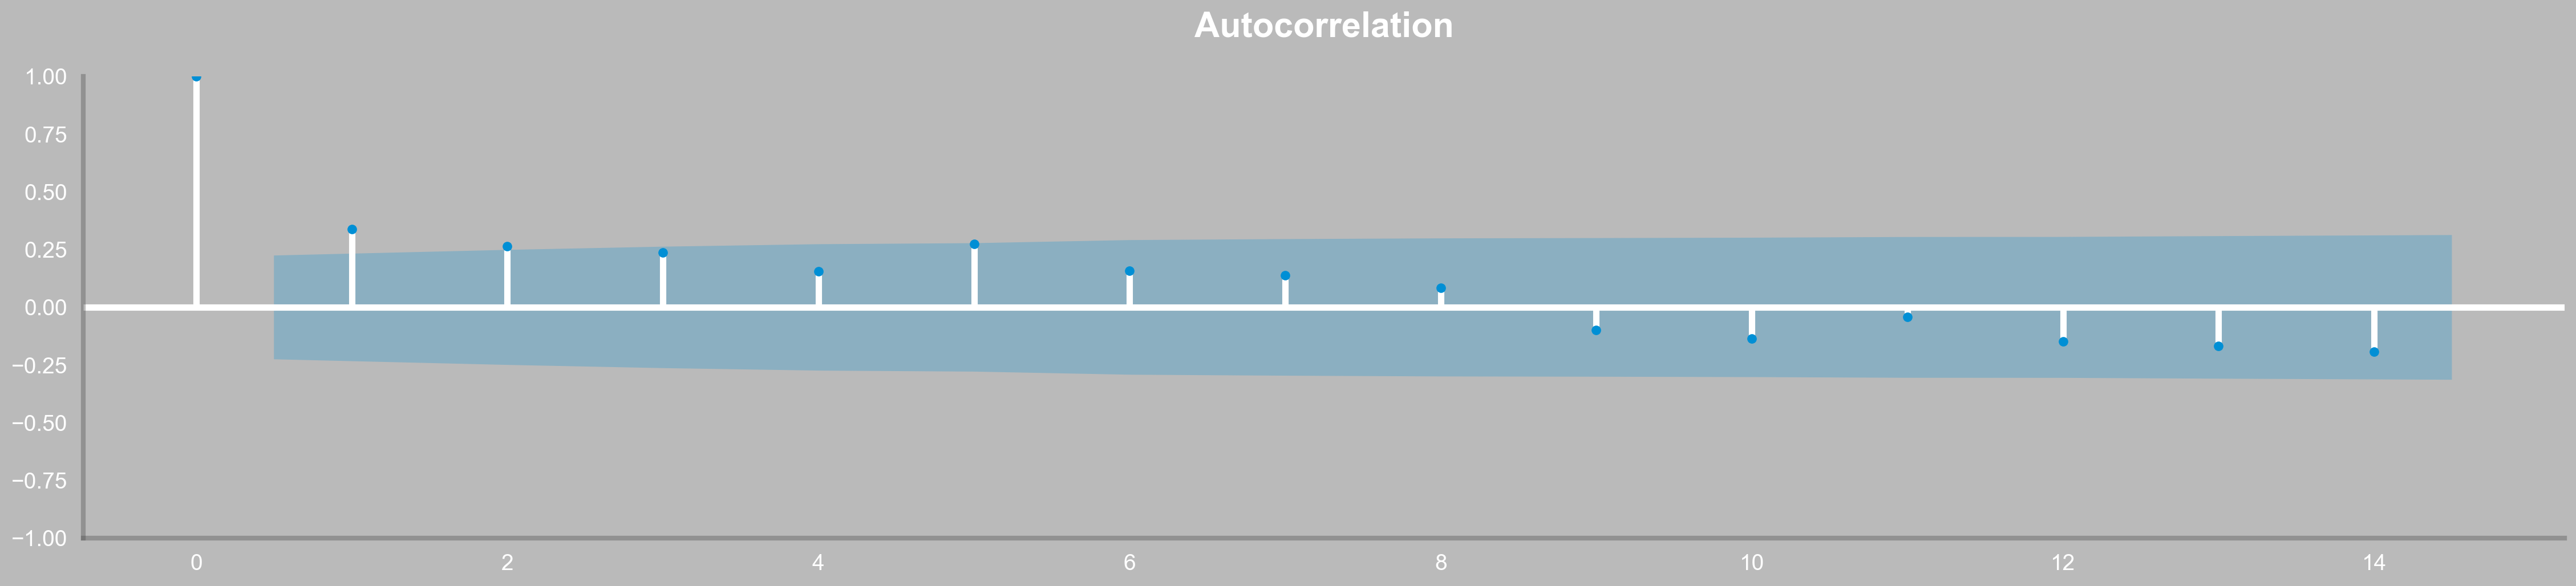

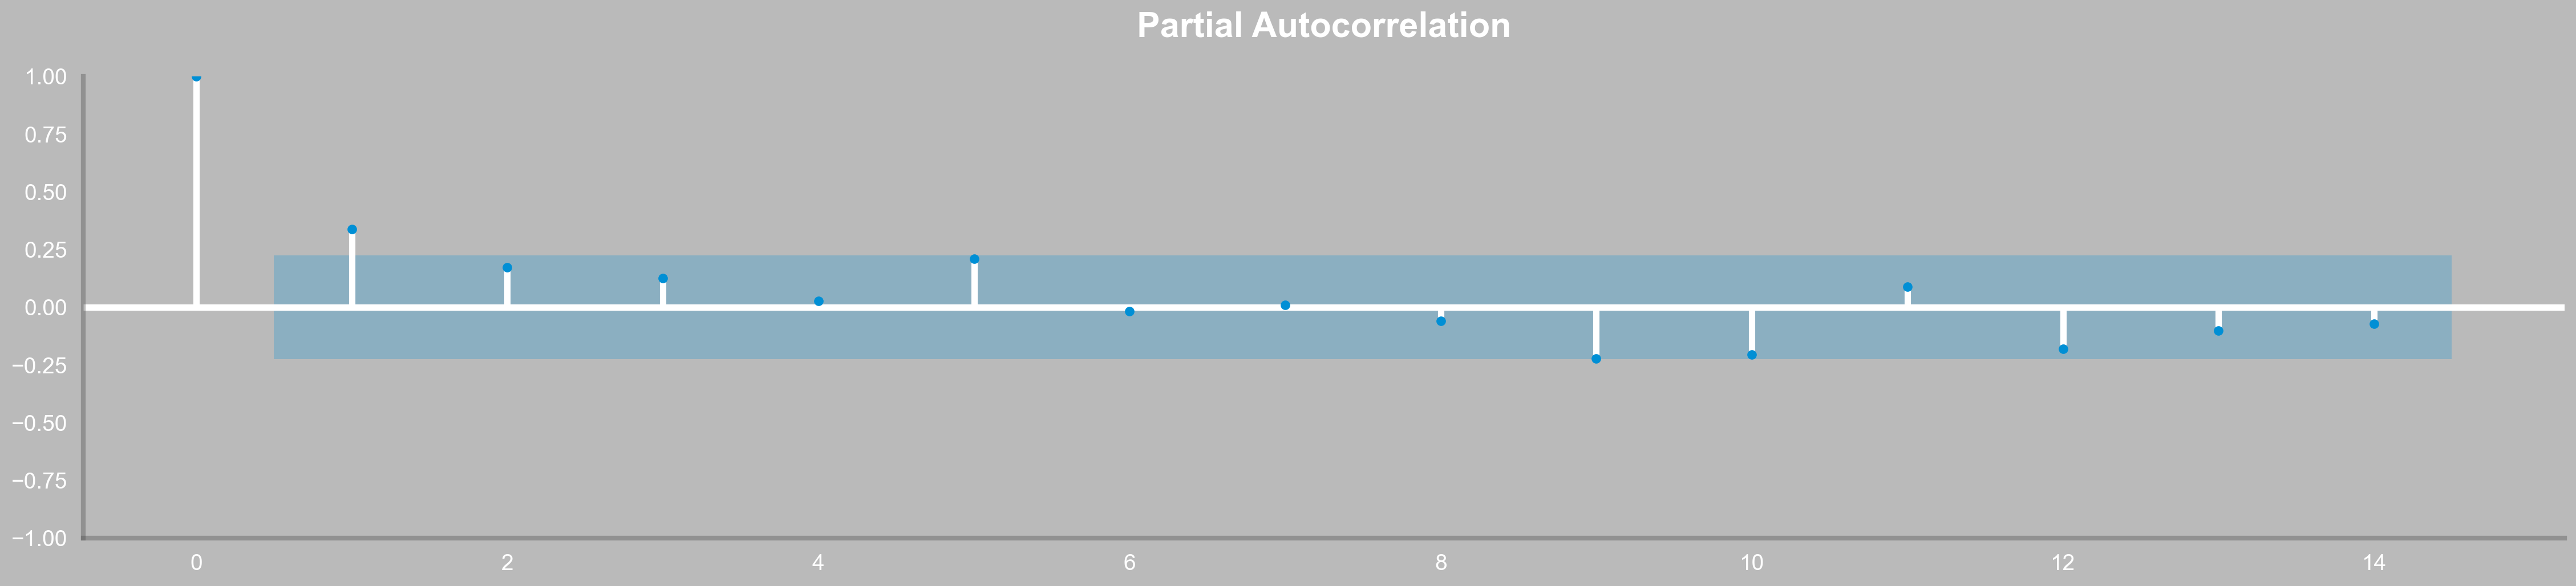

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for i in range(9, 10):
    fig, ax = plt.subplots(figsize=(25, 5))
    plot_acf(formatted_df[formatted_df.columns[i]], lags=14, ax=ax)

for i in range(9, 10):
    fig, ax = plt.subplots(figsize=(25, 5))
    plot_pacf(formatted_df[formatted_df.columns[i]], lags=14, ax=ax, method='ols')    

In [12]:
models, fc_series_dict, lower_series_dict, upper_series_dict, rmse_dict = {}, {}, {}, {}, {}

for pipe in formatted_df.columns[0:5]:
    fc_series, lower_series, upper_series, fitted, rmse = create_arima_model(df=formatted_df, 
                                                                            selected_pipe=pipe, 
                                                                            m=7,
                                                                            model_type="sarimax",
                                                                            max_p=10, max_q=10,
                                                                            trace=False)
    models[pipe], fc_series_dict[pipe], lower_series_dict[pipe] = fitted, fc_series, lower_series
    upper_series_dict[pipe], rmse_dict[pipe] = upper_series, rmse
    print(f"Pipe TTNr: {pipe} - RMSE: {rmse}")

Pipe TTNr: 8705902546 - RMSE: 1017.0959710496477
Pipe TTNr: 8716113919 - RMSE: 1065.9356995761132
Pipe TTNr: 8718640762 - RMSE: 1136.7665114588203
Pipe TTNr: 8718640763 - RMSE: 1356.1596402310538
Pipe TTNr: 8718640787 - RMSE: 1356.1596402310538


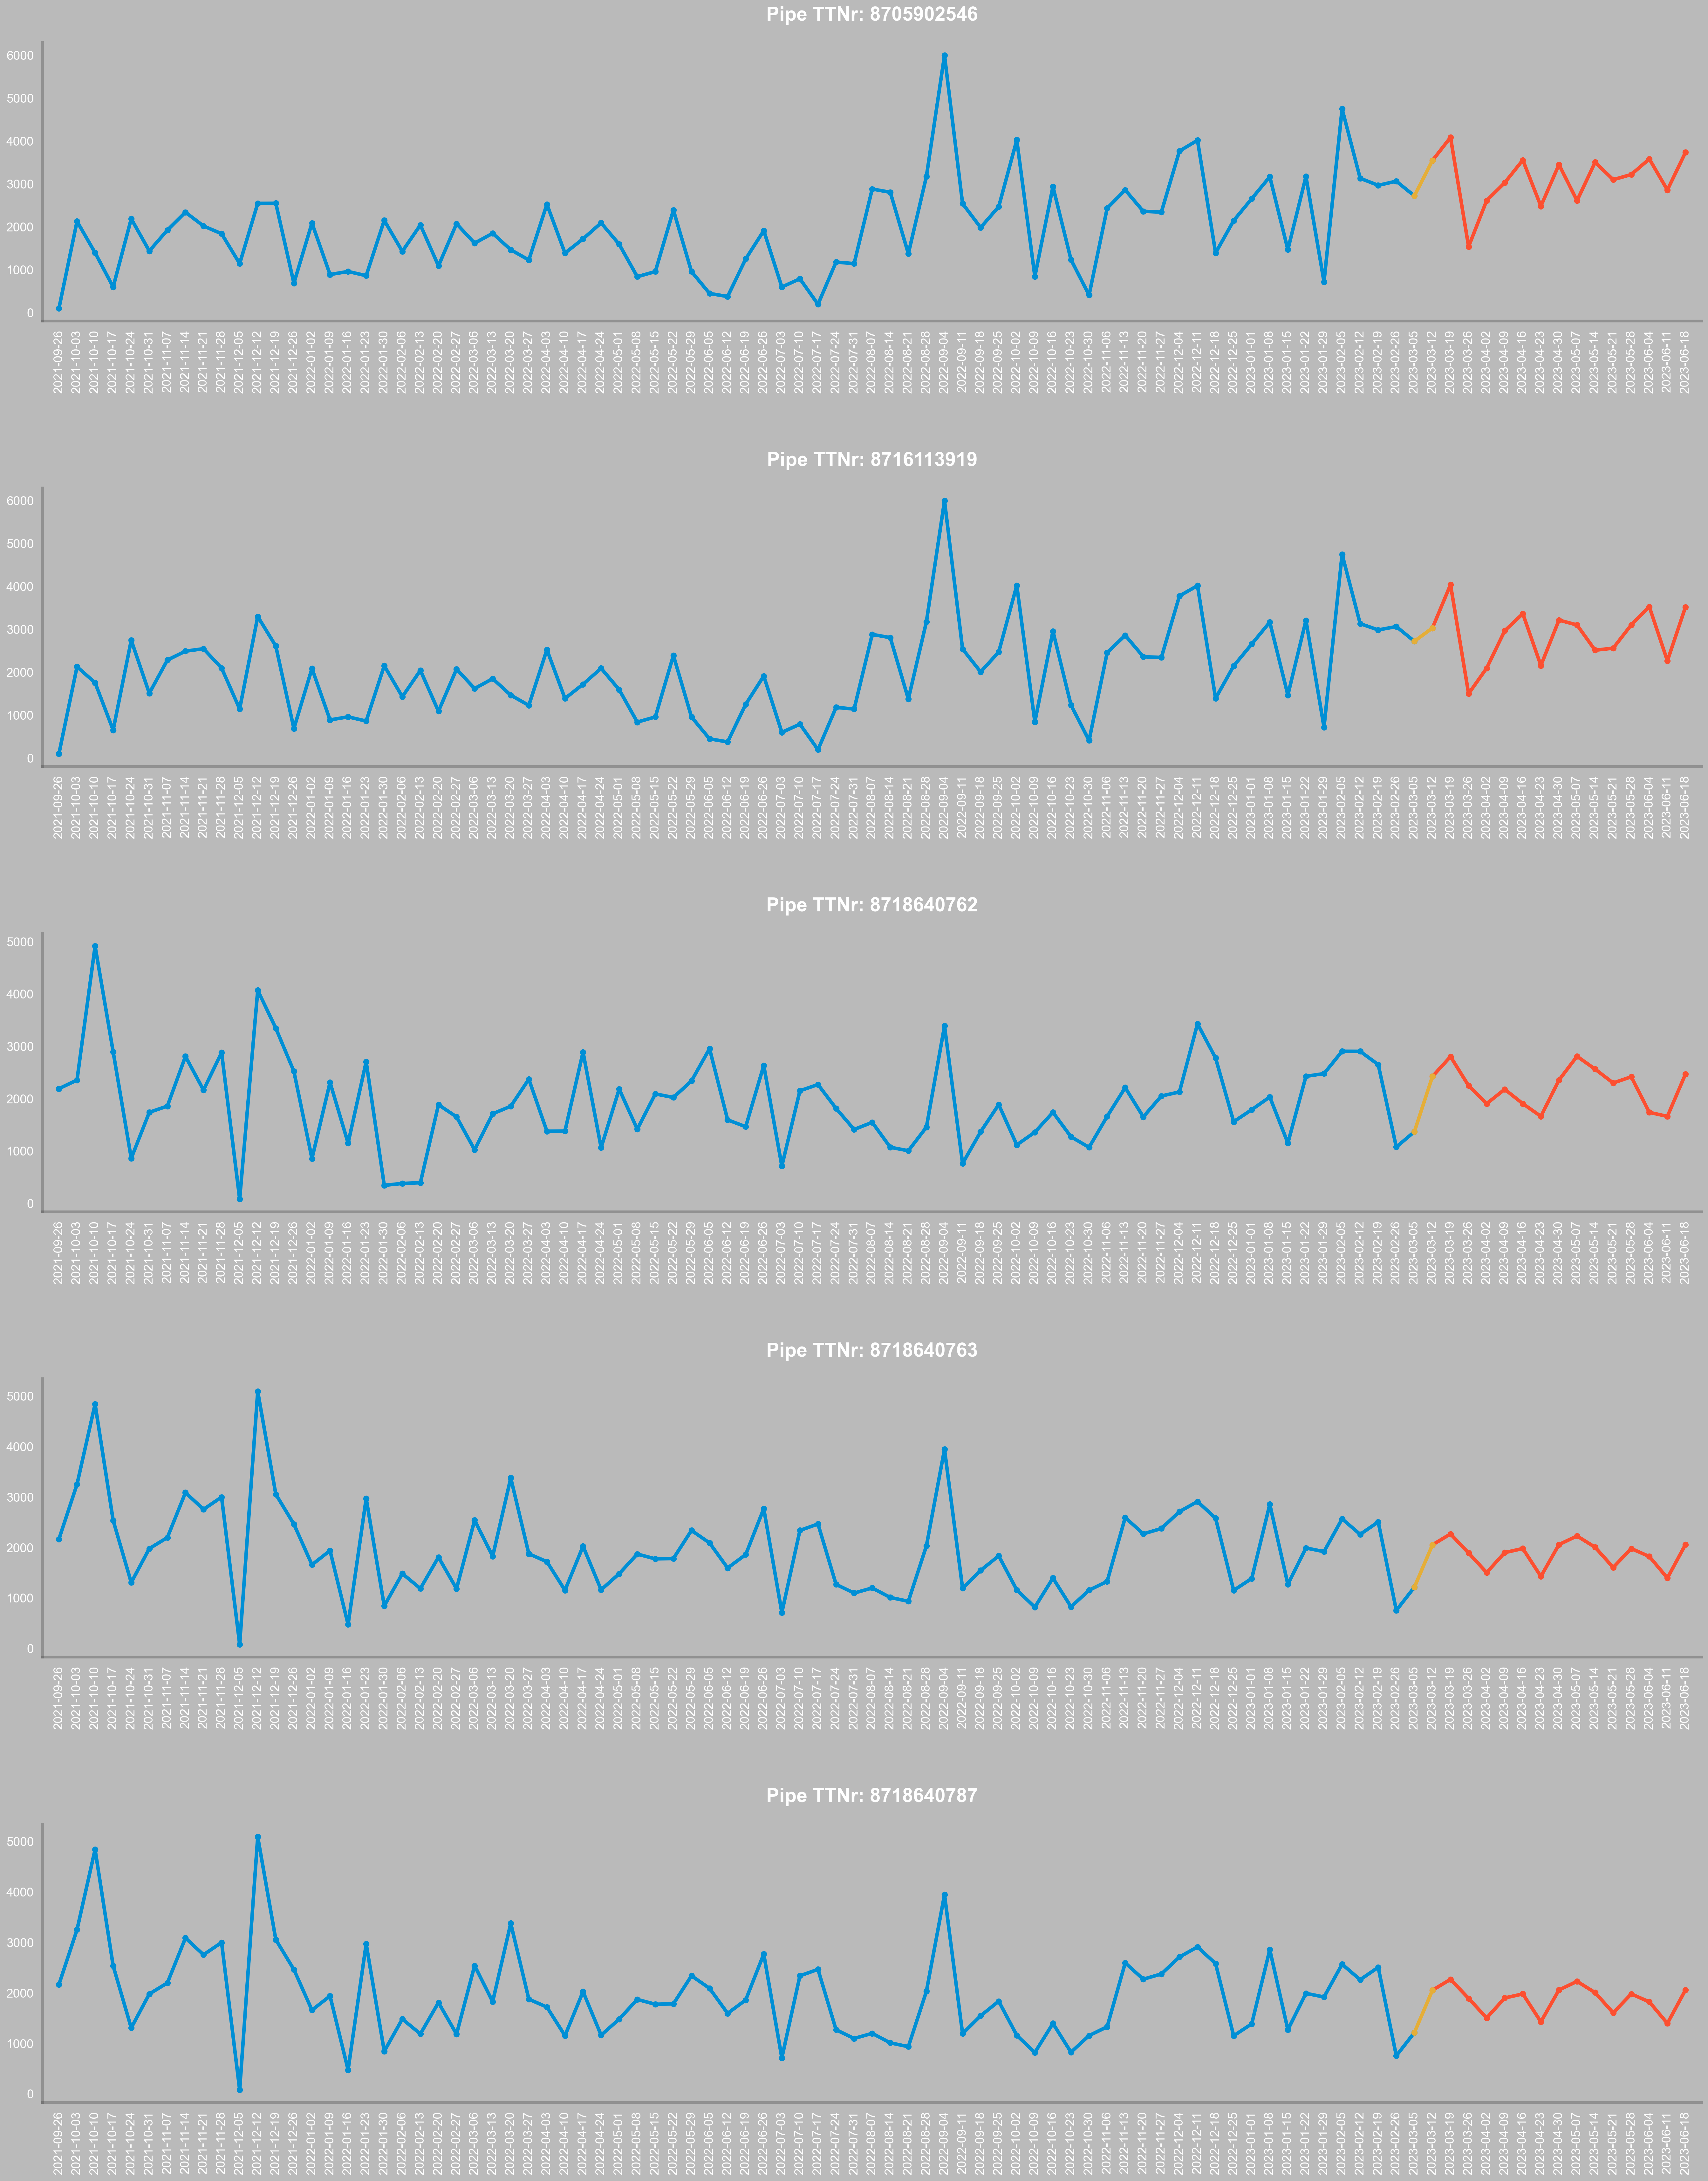

In [24]:
configure_matplotlib()
for pipe_index, pipe in enumerate(formatted_df.columns[0:5]):
    step = 15
    forecast = models[pipe].forecast(steps=step)
    forecast_df = pd.DataFrame(columns=[pipe], index=pd.date_range(start=formatted_df.index[-1] + pd.DateOffset(weeks=1), periods=step, freq='W-SUN'))
    forecast_df[pipe] = forecast

    # compare LSTM with actual values
    ax = plt.subplot(len(formatted_df.columns[0:5]), 1, pipe_index + 1)
    ax.figure.set_size_inches(30, 10 if pipe_index == 0 else pipe_index * 10)

    # plot the actual and forecast values
    ax.set_title(f"Pipe TTNr: {pipe}")
    ax.plot(formatted_df[pipe], label='training', marker='o')
    ax.plot(forecast_df[pipe], label='forecast', marker='o')
    ax.plot([formatted_df.index[-1], forecast_df.index[0]], [formatted_df[pipe].iloc[-1], forecast_df[pipe].iloc[0]], marker='o')
    plt.subplots_adjust(hspace=0.6, wspace=0)
    ax.set_xticks([*formatted_df.index, *forecast_df.index])
    ax.margins(x=0.01)
    plt.xticks(rotation=90)
    
plt.show()